# FITTING EFT COUNTERTERM TO QUIJOTE SIMULATIONS DATA

In [1]:
import numpy as np
import pandas
from scipy.interpolate import interp1d
from collections.abc import Iterable
from glob import glob

from scipy.stats import distributions
dnorm = distributions.norm.logpdf

%matplotlib inline
import matplotlib.pyplot as plt

## Data

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.11, Ob0=0.049, Om0= 0.2685)

In [3]:
fnames = glob('/Users/c49734lf/Workspace/Datasets/Quijote_simulations/Pk/matter/fiducial_HR/*/Pk_m_z=0.txt')
arrays = [np.loadtxt(f, unpack=True) for f in fnames]
k, p = arrays[0]
pk = [arrays[i][1] for i in range(len(arrays))]

In [4]:
maximum = np.amax(pk, axis=0)
minimum = np.amin(pk, axis=0)
err = maximum - minimum

In [5]:
mean = np.mean(pk, axis=0)
var = np.var(pk, axis=0)
std = np.std(pk, axis=0)

In [6]:
cov0 = np.zeros((886, 886), int)
np.fill_diagonal(cov0, var)
cov = cov0

In [3]:
k_array = np.array(k)
p_array = np.array(mean)
cov_array = var

In [8]:
p_int = interp1d( k, p, fill_value="extrapolate")
cov_int = interp1d( k, var, fill_value="extrapolate")

## Theory

In [24]:
linear = np.loadtxt("/Users/c49734lf/Workspace/2019-2020/Ongoing projects/Unequal-time EFT/modules/SPT_Quijote_fit/plin0_k2.txt", unpack=True)
klin, plin = linear

In [10]:
spt = np.loadtxt("/Users/c49734lf/Workspace/2019-2020/Ongoing projects/Unequal-time EFT/modules/SPT_Quijote_fit/pspt0_k2.txt", unpack=True)
kspt, pspt = spt

In [9]:
d = np.loadtxt('/Users/c49734lf/Workspace/2019-2020/Ongoing projects/Unequal-time EFT/GitHub modules/example/Pfastpt.txt',unpack=True)
ks = d[:, 0]
pk, p22, p13 = d[:, 1], d[:, 2], d[:, 3]

In [10]:
p11_int = interp1d( ks, pk, fill_value="extrapolate")
p22_int = interp1d( ks, p22, fill_value="extrapolate")
p13_int = interp1d( ks, p13, fill_value="extrapolate")
powerk = (p11_int, p22_int, p13_int)

In [11]:
from skypy.power_spectrum import growth_function

In [13]:
g0 = growth_function(0, cosmo)
D0 = growth_function(0, cosmo) / g0

In [14]:
import sys
sys.path.append("../")
from matter import matter_power_spectrum_1loop 

In [19]:
def peft(wavenumber, c2):
    
    if isinstance(wavenumber, pandas.Series):
        wavenumber = np.array(wavenumber)
    
    plk = p11_int(wavenumber)
    psk = matter_power_spectrum_1loop(wavenumber, D0, powerk)
    
    k2 = np.power(wavenumber, 2)
    plk_k2 = plk * k2
    
    klen = len(wavenumber)
    if isinstance(c2, Iterable):
        plk_k2 = plk_k2.reshape(klen,1)
        psk = psk.reshape(klen,1)
        
        
    return  (psk - c2 * plk_k2).T

In [66]:
kvalues = np.linspace(0.006,0.4,num=1000)
plin_model = p11_int(kvalues)
pspt_model = matter_power_spectrum_1loop(kvalues, D0, powerk)
p_data = p_int(kvalues)
cov_data = cov_int(kvalues)

def peft_model(c2):
    return peft(kvalues, c2)

In [67]:
pl_int = p11_int(klin)
pspt_int = matter_power_spectrum_1loop(klin, D0, powerk)

### Plots

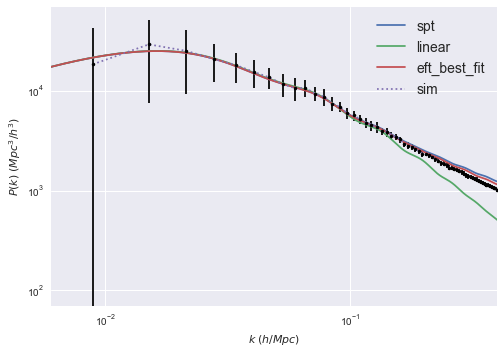

In [68]:
plt.loglog(kvalues, pspt_model, label='spt')
plt.loglog(kvalues, plin_model, label='linear')
plt.loglog(kvalues, peft_model(1), label='eft_best_fit')

plt.loglog(k, p, ':', label='sim')

plt.errorbar(k, p, yerr=err, fmt=".k", capsize=0)

plt.legend(fontsize=14)
plt.xlim(0.006, 0.4)

plt.xlabel("$k$ $(h/Mpc)$")
plt.ylabel("$P(k)$ $(Mpc^3/h^3)$");
plt.show()

## Maximum likelihood estimation

In [69]:
spt_array = p11_int(k)
lin_array = matter_power_spectrum_1loop(k, D0, powerk)

In [4]:
def log_likelihood(theta, data, covariance):
    c2 = theta
     
    model = peft_model(c2)
    
    X = data - model
    C = covariance
    X_C = X/C
    
    if isinstance(c2, Iterable):
        clen = np.size(c2)
        logprob = np.arange(clen)
        for i in range(clen): 
            logprob[i] = -0.5 * np.dot(X[i], X_C[i])
    else:
        logprob = -0.5 * np.dot(X, X /C) 
    
    return logprob

In [71]:
from scipy.optimize import minimize

c2_true = 2.0

nll = lambda *args: -log_likelihood(*args)
initial = np.array([c2_true]) 
soln = minimize(nll, initial, args=(p_data, cov_data))
c_ml = soln.x

print("Maximum likelihood estimates:")
print(c_ml)

Maximum likelihood estimates:
[2.]


## Marginalization & uncertainty estimation

In [72]:
def log_prior(theta):
    return 1/theta 

In [5]:
def log_probability(theta, data, covariance):
    return log_prior(theta) + log_likelihood(theta, data, covariance)

In [74]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(50, 1)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(p_data, cov_data))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [01:31<00:00, 54.48it/s]


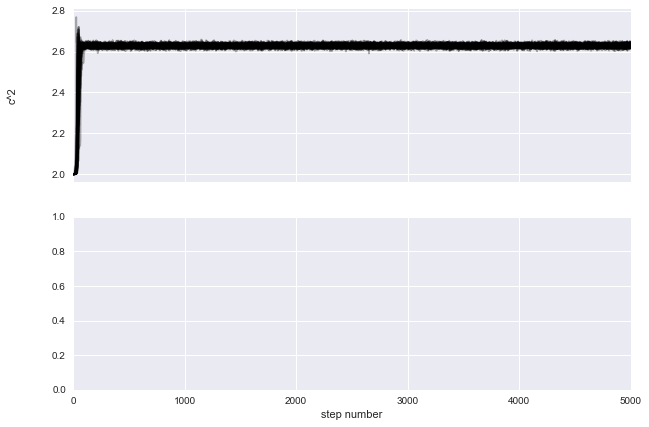

In [75]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["c^2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [76]:
tau = sampler.get_autocorr_time()
print(tau)

[49.71380759]


In [77]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 1)


## Results

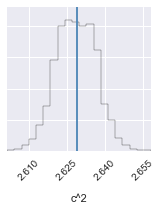

In [80]:
import corner
c2_true = 2.629
fig = corner.corner(
    flat_samples, labels=labels, truths=[c2_true]
);

<IPython.core.display.Math object>

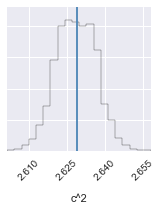

In [81]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
fig

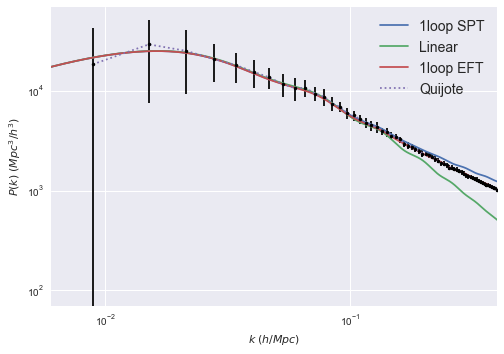

In [82]:
best_fit = mcmc[1]
#kvalues = np.linspace(0.006, 3, num=100)
plt.loglog(kvalues, pspt_model, label='1loop SPT')
plt.loglog(kvalues, plin_model, label='Linear')
plt.loglog(kvalues, peft_model(best_fit), label='1loop EFT')

plt.loglog(k, p, ':', label='Quijote')

plt.errorbar(k, p, yerr=err, fmt=".k", capsize=0)

plt.legend(fontsize=14)
plt.xlim(0.006, 0.4)
#plt.ylim(100, 20000)
plt.xlabel("$k$ $(h/Mpc)$")
plt.ylabel("$P(k)$ $(Mpc^3/h^3)$");
# plt.savefig("/Users/c49734lf/Workspace/2019-2020/Presentations/Sarahs_meetings/May_1/plots/Quijote.png")
# plt.savefig('/Users/c49734lf/Workspace/Papers/2006.xxxxx/Plots/Quijote.pdf')

In [83]:
pspt_ratio = pspt_model/p_int(kvalues)
plin_ratio = plin_model/p_int(kvalues)
peft_ratio = peft(kvalues, best_fit)/p_int(kvalues)
peft_c_ratio = peft(kvalues, 2)/p_int(kvalues)

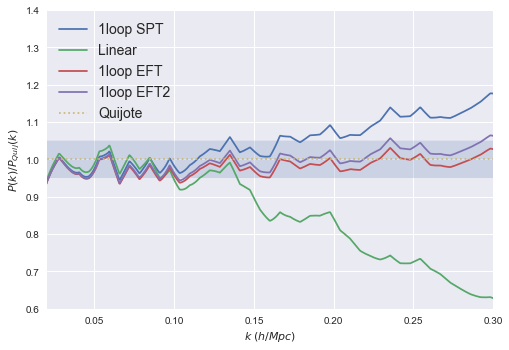

In [84]:
plt.plot(kvalues, pspt_ratio, label='1loop SPT')
plt.plot(kvalues, plin_ratio, label='Linear')
plt.plot(kvalues, peft_ratio, label='1loop EFT')
plt.plot(kvalues, peft_c_ratio, label='1loop EFT2')

plt.fill_between(kvalues, 1.05, 0.95,alpha=0.2)
plt.plot(kvalues, np.ones(len(kvalues)), ':', label='Quijote')

plt.legend(fontsize=14,loc=2)
plt.xlim(0.02, 0.3)
plt.ylim(0.6, 1.4)
plt.xlabel("$k$ $(h/Mpc)$")
plt.ylabel("$P(k)/P_{Quij}(k)$");